<a href="https://colab.research.google.com/github/Pappol/low_power_segmentation/blob/main/Low_power_cv_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with edge devices

### Challenge
The goal of this project is to develop a solution for image segmentation at the edge using the latest state of the art models on fìvery low power computational units.

This in our particular use case is based on UAV's images of natural disastes allowing for a very effective and low cost data collection in critical sitation as natural disasters such as earthquakes, volcanic eruptions and floods.

The goal is to segment this type of images with the best accuracy and the lowest amount of inference time.

### Hardware
In this project we'll use Jetson Nano computing board 2GB. This is a small low power device developed by NVIDIA that is specifically created for AI.

- Low cost of hardware: this allows to scale the system while drastically reducing the expenses
-  Lower power consumption: power consumption
- Reduced space: computational boards are very small in dimension and do not require active cooling, while GPUs can be very large and require to run other components, such as power supply which requires more space;
- Durability: not requiring moving parts as fans, edge devices are more reliable especially in outdoor situations.

### Difficulties

This advantages comes at the cost of performance and constraints, the biggest one being the amount of memory available. This is a big limitation for the use of state of the art models that are very large and require a lot of memory to be loaded and run.
A solution to this problem is to use models that are specifically designed to be run on edge devices, such as MobileNetV2, which is a very light model and quantization which allows to reduce the size of the model by reducing the precision of the weights.

## Dependecies

In [ ]:
#link drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [ ]:
#unpack dataset
! unzip /content/drive/MyDrive/LPCVC_Train_Updated.zip
! unzip /content/drive/MyDrive/LPCVC_Val.zip


In [ ]:
!pip install wandb -q
! pip install -U accelerate -q
! pip install -U transformers -q

In [40]:
from copy import deepcopy
from transformers import TrainerCallback
import numpy as np
from transformers import AutoImageProcessor, MobileNetV2ForSemanticSegmentation, Trainer, TrainingArguments
from PIL import Image
import torch
import torch.nn as nn
from matplotlib.colors import ListedColormap
import os
from torch.utils.data import Dataset
from torchvision import transforms
import random
import torchvision
import torch.nn.functional as F
from transformers import TrainerCallback
from transformers.modeling_outputs import SemanticSegmenterOutput
from typing import Optional, Union
import cv2


In [4]:
import wandb
wandb.init(project="cv-low_power_seg")

wandb.log({"Test": 1})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: pappol. Use `wandb login --relogin` to force relogin
cat: /sys/module/amdgpu/initstate: File o directory non esistente
ERROR:root:Driver not initialized (amdgpu not found in modules)


## Metrics for evaluation


In [5]:
class AccuracyTracker(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask],
            minlength=n_class**2,
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(
                lt.flatten(), lp.flatten(), self.n_classes
            )

    def get_scores(self):
        """Returns accuracy score evaluation result.
        - overall accuracy
        - mean accuracy
        - mean IU
        - fwavacc
        """
        hist = self.confusion_matrix
        self.acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / (hist.sum(axis=1) + 0.000000001)
        self.acc_cls = np.nanmean(acc_cls)

        with np.errstate(invalid='ignore'):
            dice = 2*np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0))

        self.mean_dice = np.nanmean(dice)
        freq = hist.sum(axis=1) / hist.sum()
        self.fwavacc = (freq[freq > 0] * dice[freq > 0]).sum()
        self.cls_dice = dict(zip(range(self.n_classes), dice))

        return {
            "Overall Acc: \t": self.acc,
            "Mean Acc : \t": self.acc_cls,
            "FreqW Acc : \t": self.fwavacc,
            "Mean Dice : \t": self.mean_dice,
        }


## Dataset implementation

In [6]:
class lpcv_dataset(Dataset):
    def __init__(self, image_folder, label_folder, image_processor, transform=None, augmentation=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.image_filenames = sorted(os.listdir(image_folder))  # Sort filenames
        self.transform = transform
        self.augmentation = augmentation
        self.image_processor = image_processor

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_folder, image_filename)

        # Generate corresponding label filename
        label_path = os.path.join(self.label_folder, image_filename)

        image = Image.open(image_path).convert("RGB")
        label = np.asarray(Image.open(label_path))[:,:,0]

        if self.augmentation:
            image, label = self.augmentation(image, label)

        # Scale image pixel values to [0, 1] range
        image = np.array(image) / 255.0

        # Preprocess the image using the image_processor
        inputs = self.image_processor(images=image, return_tensors="pt")


        #remove the 3rd dimension from input
        inputs["pixel_values"] = inputs["pixel_values"].squeeze(0)

        return {"pixel_values": inputs["pixel_values"], "labels": torch.tensor(label, dtype=torch.long)}

In [7]:
def augmentation(image, label, angle_range=15, target_size=(512, 512)):
    #convert lable into PIL image
    label = Image.fromarray(label)

    #random horizontal flip
    if random.random() > 0.8:
        image = torchvision.transforms.functional.hflip(image)
        #print lable type
        label = torchvision.transforms.functional.hflip(label)

    #random vertical flip
    if random.random() > 0.5:
        image = torchvision.transforms.functional.vflip(image)
        label = torchvision.transforms.functional.vflip(label)

    #convert label into numpy array
    label = np.asarray(label)

    return image, label



## Model setup

In [8]:
#class for the model with the segmentation head to match desired output
class Mobile_segment(MobileNetV2ForSemanticSegmentation):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(320, 14, kernel_size=1, stride=1),  # Adjust output channels to 14
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )


        def forward(
            self,
            pixel_values: Optional[torch.Tensor] = None,
            labels: Optional[torch.Tensor] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
        ) -> Union[tuple, SemanticSegmenterOutput]:

            output_hidden_states = (output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states)
            return_dict = return_dict if return_dict is not None else self.config.use_return_dict

            outputs = self.mobilenet_v2(
                pixel_values,
                output_hidden_states=True,  # we need the intermediate hidden states
                return_dict=return_dict,
            )

            encoder_hidden_states = outputs.hidden_states if return_dict else outputs[1]

            logits = self.segmentation_head(encoder_hidden_states[-1])
            print(logits.shape)
            logits = self.segmentation_head(logits)

            loss = None
            if labels is not None:
                if self.config.num_labels == 1:
                    raise ValueError("The number of labels should be greater than one")
                else:
                    # upsample logits to the images' original size
                    upsampled_logits = nn.functional.interpolate(
                        logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                    )
                    loss_fct = super.CrossEntropyLoss(ignore_index=self.config.semantic_loss_ignore_index)
                    loss = loss_fct(upsampled_logits, labels)

            if not return_dict:
                if output_hidden_states:
                    output = (logits,) + outputs[1:]
                else:
                    output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return SemanticSegmenterOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states if output_hidden_states else None,
                attentions=None,
            )


In [9]:
class CustomTrainer(Trainer):
    def __init__(self, *args, accuracy_tracker, **kwargs):
        super().__init__(*args, **kwargs)
        self.accuracy_tracker = accuracy_tracker

    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        # Calculate and print accuracy metrics at the end of an epoch
        accuracy_scores = self.accuracy_tracker.get_scores()
        wandb.log({"Accuracy": accuracy_scores[0]})

        super().on_epoch_end(args, state, control, logs=logs, **kwargs)


    def evaluation_step(self, model, inputs):
        loss, logits = super().evaluation_step(model, inputs)
        self.accuracy_tracker.update(inputs["labels"], logits.argmax(dim=1))
        return loss, logits
    
    
class CustomCallback(TrainerCallback):
    def __init__(self, trainer, accuracy_tracker, eval_dataset) -> None:
        super().__init__()
        self._trainer = trainer
        self.accuracy_tracker = accuracy_tracker
        self.eval_dataset = eval_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)

            # Evaluate on the provided evaluation dataset
            self._trainer.evaluate(eval_dataset=self.eval_dataset)

            # Get label trues and label preds for accuracy tracking
            label_trues = self._trainer.callback_metrics['label_ids']
            label_preds = self._trainer.callback_metrics['predictions']
            self.accuracy_tracker.update(label_trues, label_preds)

            # Get accuracy scores
            accuracy_scores = self.accuracy_tracker.get_scores()

            # Log metrics using WandB
            wandb.log(accuracy_scores, step=self._trainer.state.epoch)

            return control_copy


## Training

In [10]:
categories = ["background", "avalanche",
              "building_undamaged", "building_damaged",
              "cracks/fissure/subsidence", "debris/mud/rock flow",
              "fire/flare", "flood/water/river/sea",
              "ice_jam_flow", "lava_flow",
              "person", "pyroclastic_flow",
              "road/railway/bridge", "vehicle"]

colors = ['black', 'white', 'pink', 'yellow', 'orange', 'brown',
          'red', 'blue', 'navy', 'orange', 'cyan', 'gray',
          'magenta']

#import changing initial resulution and number of classes
image_processor = AutoImageProcessor.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513",
                                                     num_labels=len(categories),
                                                     ignore_mismatched_sizes=True,
                                                     crop_size=(512, 512))

model = MobileNetV2ForSemanticSegmentation.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513",
                                                           num_labels=len(categories),
                                                           ignore_mismatched_sizes=True,
                                                           image_size=(512, 512))



image_folder="dataset/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/IMG/train"
label_folder="dataset/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/GT_Updated/train"

val_folder="dataset/LPCVC_Val/LPCVC_Val/IMG/val"
val_label_folder="dataset/LPCVC_Val/LPCVC_Val/GT/val"

train_dataset = lpcv_dataset(image_folder, label_folder, image_processor, augmentation=augmentation)

accuracy_tracker = AccuracyTracker(len(categories))



Some weights of MobileNetV2ForSemanticSegmentation were not initialized from the model checkpoint at google/deeplabv3_mobilenet_v2_1.0_513 and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([14, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
custom_trainer = CustomTrainer(
    model=model,
    args= TrainingArguments(output_dir="test_trainer", num_train_epochs=100, per_device_train_batch_size=8),
    train_dataset=train_dataset,
    eval_dataset= lpcv_dataset(val_folder, val_label_folder, image_processor),
    accuracy_tracker= accuracy_tracker
)

eval_callback = CustomCallback(trainer=custom_trainer, accuracy_tracker=accuracy_tracker, eval_dataset=lpcv_dataset(val_folder, val_label_folder,image_processor ))

custom_trainer.add_callback(eval_callback)

#custom_trainer.train() #uncomment to train the model

<img src="W&B Chart 1_9_2023, 15_45_28.png" style="width: 60%;"/>

## Model quantization

Usually, on edge devices, operations with floating points are very computationally demanding. Quantization is one of the most effective Tiny machine learning techniques for reducing computing time and energy needed by neural networks. The weights and activation tensors in neural network quantization are stored in lower bit precision than the 16 or 32 bits they are typically trained in. While the computational cost for matrix multiplication lowers by a factor of 16 when switching from 32 to 8 bits, the memory overhead for storing tensors decreases by a factor of 4. The main operations in neural networks are matrix multiplications, in \cref{fig:calc} is depicted how  $y = Wx + b$ is calculated.

<img src='https://drive.google.com/uc?id=1V0sQ3RpodWxFO0_Tan8rYt-9VeRb9CLm' style="width: 70%;">

The operation is composed of: *processing elements* $C_{n,m}$, *accumulators* ($A_n$), *weights* $W_{n,m}$, and *bias* $b_n$.

When $C_{n,m}=W_{n,m}*x_m$, the result of the multiplication is represented as:

\begin{equation}
    A_n=b_n+\sum_{m}C_{n,m}
\end{equation}

A floating point can be easily converted into a fixed point with simple multiplication. $\hat{x}$ can be approximated as a scalar multiplied by a vector of integer values: $\hat{X} = S_x\cdot X_{int} \approx	X$. By quantifying the weights and activation, we can write the quantified version of the accumulation equation as:

\begin{equation}
    A_n=b_n+s_w s_x\sum_{m}W^{int}_{n,m} x^{int}_{n,m}
\end{equation}


<img src='https://drive.google.com/uc?id=10DHXc9PvojhMcwNTjSS0LsIrL8Z37dWs' style="width: 70%;">

The process of quantization should not only simplify the operations but also reduces the size of the model too. In this case, the net is trained normally and then is applied quantization, this process is called knowledge distillation. It allows for a lower impact on performances since the reduction is applied only after training.  Knowledge distillation is a very used process in TinyML because it is used to transfer the training process to a smaller model reducing the degradation caused by the reduction. Quantization is a well-known strategy and it is used in different fields from signal processing to compression and its results are valid.

https://arxiv.org/pdf/2106.08295.pdf

In [12]:
# Set the model to evaluation mode
model.eval()

# Convert the model to quantized version
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Save the model
torch.save(quantized_model, 'model_quantized.pt')

## Test on one image

In [38]:
def test_model(img_path, save_path, model, preprocess):

    image = Image.open(img_path)
    inputs = image_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits

    # Post-process logits into segmentation mask
    segmentation_mask = torch.argmax(logits, dim=1)

    # Convert segmentation mask to colored image (assuming 14 color channels)
    colored_image = ListedColormap(colors)(segmentation_mask[0].cpu().numpy())

    #save the image
    Image.fromarray((colored_image * 255).astype(np.uint8)).save(f"segmented_image.png")

In [14]:
#LOAD THE MODEL
loaded_model = Mobile_segment.from_pretrained("models/Mobile_segmentationv2")

250


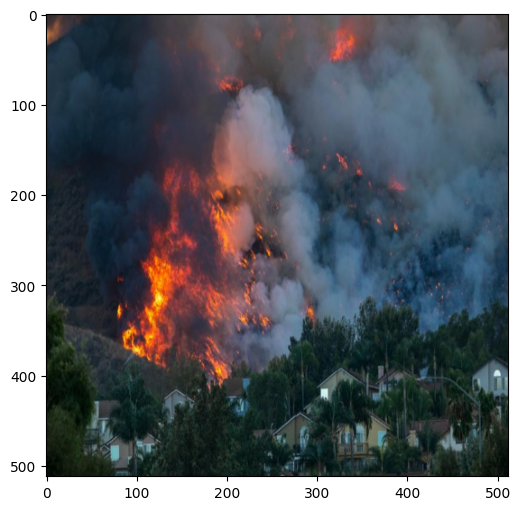

In [21]:
import matplotlib.pyplot as plt

folderPath = '/home/pappol/Scrivania/uni/cv/low_power_segmentation/dataset/LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated'
seed= random.randint(0, 1020)
print(f'{seed:03d}')
imagePath = f'{folderPath}/IMG/train/train_0{seed:03d}.png'

#Visualize image
img = Image.open(imagePath)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.show()

(512, 512)


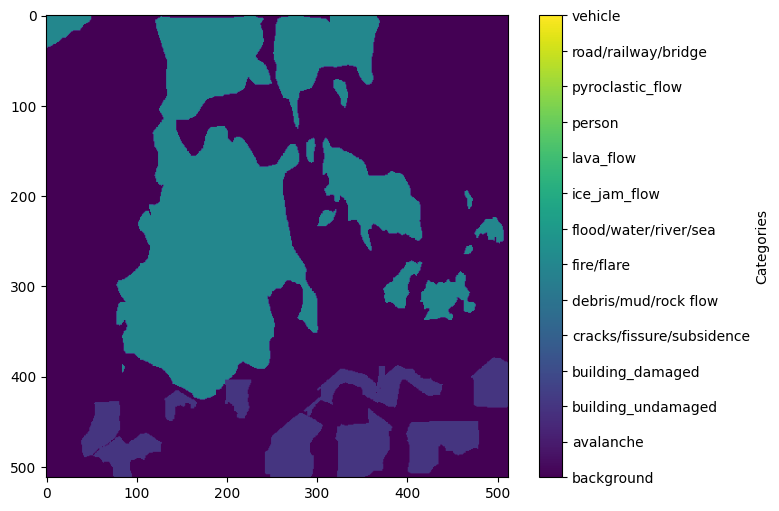

In [28]:
from matplotlib.colors import ListedColormap

def printSEGMENTATION(filepath):
    # Define the colors for each value in the matrix
    cmap = ListedColormap(colors)

    mask = np.asarray(Image.open(filepath))[:,:,0]
    print(mask.shape)
    plt.figure(figsize=(8, 6))
    plt.imshow(mask, vmin=0, vmax=13)
    cbar = plt.colorbar(ticks=np.arange(14), label='Categories')
    # cbar = plt.colorbar(ticks=np.arange(14), cmap = cmap, label='Categories')
    cbar.ax.set_yticklabels(categories)
    plt.show()
    #save the image


printSEGMENTATION(f"{folderPath}/GT_Updated/train/train_0{seed:03d}.png")

(512, 512)


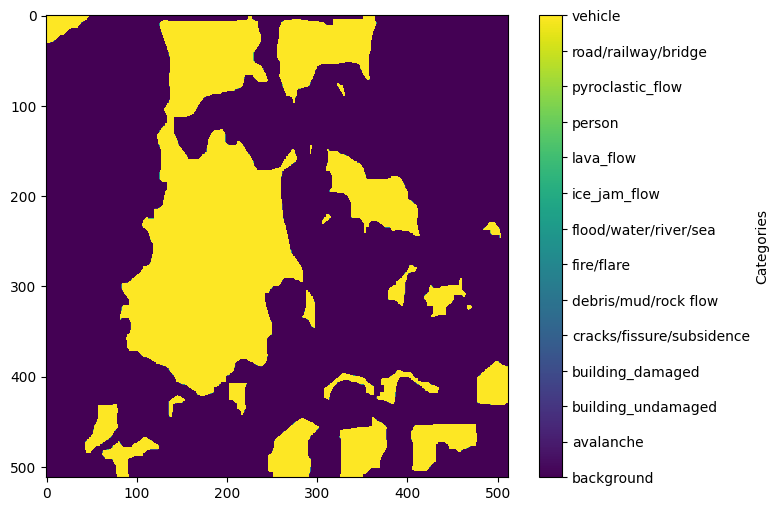

In [42]:
test_model(imagePath, "test.png", loaded_model, image_processor )
printSEGMENTATION("segmented_image_.png")